## Object Detection

AttributeError: 'str' object has no attribute 'show'

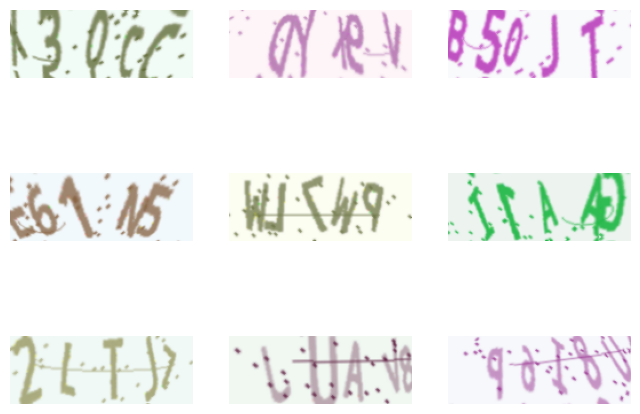

In [ ]:
from fastai.vision.all import *
from datasets import Dataset
from captcha.image import ImageCaptcha
import random
import string

# 1. Create a fake CAPTCHA dataset
def create_captcha_dataset(size=100):
    generator = ImageCaptcha(width=160, height=60)
    data = []
    for _ in range(size):
        label = ''.join(random.choices(string.ascii_uppercase + string.digits, k=5))
        img = generator.generate_image(label)
        data.append({'image': img, 'label': label})
    return Dataset.from_list(data)

# 2. Generate the dataset
ds = create_captcha_dataset(100)

# 3. Define the vocabulary
vocab = list(string.ascii_uppercase + string.digits)
vocab_dict = {v: k for k, v in enumerate(vocab)}

# 4. Define the custom TransformBlock for tokenizing labels
class TokenizeLabel(Transform):
    def __init__(self, vocab):
        self.vocab = vocab
        self.o2i = {v: k for k, v in enumerate(vocab)}
    
    def encodes(self, x):
        if isinstance(x, str):  # Handle string input
            indices = [self.o2i[c] for c in x]
            return TensorText(tensor(indices))
        return x  # Already encoded
    
    def decodes(self, x):
        if isinstance(x, (Tensor, ndarray)):  # Handle tensor input
            return ''.join([self.vocab[int(i)] for i in x])
        return x  # Already decoded

# 5. Define the DataBlock
dblock = DataBlock(
    blocks=(ImageBlock, TransformBlock(type_tfms=TokenizeLabel(vocab))),
    get_x=lambda o: PILImage.create(o['image']),
    get_y=lambda o: list(o['label']),
    splitter=RandomSplitter(),
    item_tfms=None,
    batch_tfms=aug_transforms(
        do_flip=True,
        flip_vert=False,
        max_rotate=10,
        max_zoom=1.1,
        max_lighting=0.2,
        max_warp=0.2,
        p_affine=0.75,
        p_lighting=0.75
    )
)

# 6. Create DataLoaders
dls = dblock.dataloaders(ds, bs=16)

# 7. Visualize a batch
dls.show_batch(max_n=9, figsize=(8,6))


In [1]:
from fastai.vision.all import *
from fastai.text.all import *

In [2]:
import torch.multiprocessing as mp
# Set the multiprocessing start method to 'spawn'
if __name__ == "__main__":
    mp.set_start_method('spawn', force=True)

In [3]:
from transformers import VisionEncoderDecoderModel, TrOCRProcessor, Seq2SeqTrainer, Seq2SeqTrainingArguments
from datasets import Dataset
from captcha.image import ImageCaptcha
from PIL import Image
import random
import torch

2025-05-02 18:34:10.830452: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746236050.841233   86360 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746236050.844480   86360 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746236050.853589   86360 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746236050.853599   86360 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746236050.853600   86360 computation_placer.cc:177] computation placer alr

In [4]:
# 1. Create a fake CAPTCHA dataset
def create_captcha_dataset(size=100):
    generator = ImageCaptcha(width=160, height=60)
    data = []
    for _ in range(size):
        label = ''.join(random.choices('ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789', k=5))
        img = generator.generate_image(label)
        data.append({'image': img, 'label': label})
    return Dataset.from_list(data)

In [5]:
ds = create_captcha_dataset(1000)

In [13]:
vocab = list(string.ascii_uppercase + string.digits)
vocab_dict = {v: k for k, v in enumerate(vocab)}

# 4. Define the custom TransformBlock for tokenizing labels
class TokenizeLabel(Transform):
    def __init__(self, vocab):
        self.vocab = vocab
        self.o2i = {v: k for k, v in enumerate(vocab)}
    
    def encodes(self, x):
        indices = [self.o2i[c] for c in x]
        return TensorText(tensor(indices))
    
    def decodes(self, x):
        return ''.join([self.vocab[int(i)] for i in x])

In [14]:
dblock = DataBlock(
    blocks=(ImageBlock, TransformBlock(type_tfms=TokenizeLabel(vocab))),
    get_x=lambda o: PILImage.create(o['image']),
    get_y=lambda o: list(o['label']),
    splitter=RandomSplitter(),
    item_tfms=None,
    batch_tfms=aug_transforms(
        do_flip=True,
        flip_vert=False,
        max_rotate=10,
        max_zoom=1.1,
        max_lighting=0.2,
        max_warp=0.2,
        p_affine=0.75,
        p_lighting=0.75
    )
)

In [15]:
# 4. Create DataLoaders
dls = dblock.dataloaders(ds)

AttributeError: 'str' object has no attribute 'show'

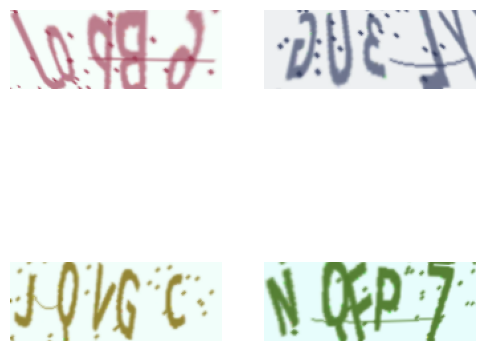

In [16]:
dls.show_batch(max_n=4)

In [ ]:
from fastai.vision.all import *


In [5]:
from transformers import Trainer, TrainingArguments
from torchvision import transforms
from datasets import Dataset
import torch
from torch.nn.utils.rnn import pad_sequence
import numpy as np
from PIL import Image

# 1. Define Augmentations
train_transform = transforms.Compose([
    transforms.RandomRotation(5, fill=(255,)),  # Fill with white for rotation
    transforms.ColorJitter(0.1, 0.1, 0.1),
    transforms.RandomPerspective(distortion_scale=0.1, p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



# 3. Character Tokenizer
class CharTokenizer:
    def __init__(self, chars):
        self.char_to_id = {c:i+1 for i,c in enumerate(chars)}  # 0 is padding
        self.id_to_char = {i+1:c for i,c in enumerate(chars)}
        self.blank_token = 0

    def encode(self, text):
        return [self.char_to_id[c] for c in text]

    def decode(self, ids):
        return ''.join([self.id_to_char[i] for i in ids if i != self.blank_token])



# 2. Dataset Preprocessing (Updated)
def preprocess_data(examples, tokenizer, augment=False):
    """Process a batch of examples from the dataset."""
    # Initialize empty lists for processed data
    pixel_values = []
    labels = []
    
    # Process each image and label pair
    for img, text in zip(examples['image'], examples['label']):
        # Apply transforms to image
        transform = train_transform if augment else val_transform
        img_tensor = transform(img)
        
        # Tokenize text
        label_ids = tokenizer.encode(text)
        
        # Store processed data
        pixel_values.append(img_tensor)
        labels.append(label_ids)
    
    # Return as dictionary with lists (not nested lists)
    return {
        'pixel_values': pixel_values,
        'labels': labels
    }
# Custom collate function with device handling
def custom_collate_fn(features):
    """Custom collate function to handle batches of features."""
    # Extract features
    pixel_values = [feature['pixel_values'] for feature in features]
    labels = [feature['labels'] for feature in features]
    
    # Convert label lists to tensors
    labels = [torch.tensor(label, dtype=torch.long) for label in labels]
    
    # Pad labels
    padded_labels = pad_sequence(labels, batch_first=True, padding_value=tokenizer.blank_token)
    
    # Stack pixel values - ensure they're tensors
    pixel_tensor_batch = torch.stack([
        p if isinstance(p, torch.Tensor) else torch.tensor(p) 
        for p in pixel_values
    ])
    
    # Return batch - DON'T move to device here, let the DataLoader handle it
    return {
        'pixel_values': pixel_tensor_batch,
        'labels': padded_labels
    }

# 5. Training Setup
chars = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
tokenizer = CharTokenizer(chars)

In [6]:
# After creating your tokenizer in cell 4, add this code to preprocess your datasets:
def preprocess_dataset(dataset, tokenizer, augment=False):
    """Apply preprocessing to a complete dataset"""
    return dataset.map(
        lambda batch: preprocess_data(batch, tokenizer, augment),
        batched=True, 
        batch_size=16
    )

# Process the datasets
train_dataset = preprocess_dataset(train_dataset, tokenizer, augment=True)
val_dataset = preprocess_dataset(val_dataset, tokenizer, augment=False)


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [7]:
# 6. Metrics for Evaluation
def compute_metrics(p):
    pred_ids = np.argmax(p.predictions, axis=-1)
    pred_texts = [tokenizer.decode(ids) for ids in pred_ids]
    label_texts = [tokenizer.decode(ids) for ids in p.label_ids]

    # Calculate character and word accuracy
    char_acc = np.mean([
        sum(a==b for a,b in zip(pred, label)) / max(len(pred), len(label))
        for pred, label in zip(pred_texts, label_texts)
    ])

    word_acc = np.mean([pred == label for pred, label in zip(pred_texts, label_texts)])

    return {'char_accuracy': char_acc, 'word_accuracy': word_acc}

In [8]:

import torch
import torch.nn as nn
from torchvision import models

class CaptchaModel(nn.Module):
    def __init__(self, num_chars):
        super().__init__()
        # CNN backbone (ResNet18 without final layer)
        self.cnn = models.resnet18(weights='IMAGENET1K_V1')
        self.cnn = nn.Sequential(*list(self.cnn.children())[:-2])  # Remove avgpool and fc

        # LSTM decoder
        self.lstm = nn.LSTM(
            input_size=512,  # ResNet18 feature size
            hidden_size=128,
            num_layers=2,
            bidirectional=True,
            batch_first=True
        )

        # Output layer
        self.fc = nn.Linear(256, num_chars + 1)  # +1 for CTC blank token
        
        # CTC Loss
        self.ctc_loss = nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True)

    def forward(self, pixel_values, labels=None):
        # CNN features
        features = self.cnn(pixel_values)  # [batch, 512, h, w]
        batch_size = features.size(0)
        features = features.permute(0, 3, 1, 2)  # [batch, w, 512, h]
        features = features.mean(dim=3)  # [batch, w, 512]

        # LSTM sequence processing
        lstm_out, _ = self.lstm(features)  # [batch, w, 256] (bidirectional)

        # Classifier
        logits = self.fc(lstm_out)  # [batch, w, num_chars+1]
        log_probs = torch.nn.functional.log_softmax(logits, dim=2)

        loss = None
        if labels is not None:
            # Create valid input_lengths - must be >= target lengths for CTC
            input_lengths = torch.full(
                size=(batch_size,),
                fill_value=logits.size(1),
                dtype=torch.long,
                device=logits.device
            )
            
            # Calculate valid target_lengths
            target_lengths = torch.sum(labels != 0, dim=1).to(logits.device)
            
            # Make sure no target_length is zero
            target_lengths = torch.clamp(target_lengths, min=1)
            
            # Ensure input sequences are longer than target sequences (CTC requirement)
            if logits.size(1) > 1:  # At least 2 timesteps required for CTC
                try:
                    # CTC loss expects [T, N, C] format
                    log_probs_T = log_probs.permute(1, 0, 2)
                    
                    # Handle potential numerical issues
                    log_probs_T = torch.clamp(log_probs_T, min=-50.0, max=50.0)
                    
                    loss = self.ctc_loss(
                        log_probs_T,
                        labels,
                        input_lengths,
                        target_lengths
                    )
                    
                    # Handle NaN loss
                    if torch.isnan(loss) or torch.isinf(loss):
                        print("Warning: NaN or Inf loss detected")
                        loss = torch.tensor(0.0, device=logits.device, requires_grad=True)
                except Exception as e:
                    print(f"CTC Loss error: {e}")
                    print(f"Shapes - logits: {logits.shape}, labels: {labels.shape}")
                    print(f"input_lengths: {input_lengths}, target_lengths: {target_lengths}")
                    loss = torch.tensor(0.0, device=logits.device, requires_grad=True)
            else:
                # Fallback for sequences too short
                loss = torch.tensor(0.0, device=logits.device, requires_grad=True)
                
        return {'loss': loss, 'logits': logits} if loss is not None else {'logits': logits}


In [10]:
  # 7. Training Arguments
training_args = TrainingArguments(
    output_dir='./results',
    per_device_train_batch_size=32,         # Batch size per GPU
    per_device_eval_batch_size=32,          # Evaluation batch size per GPU
    eval_strategy="epoch",
    num_train_epochs=20,
    learning_rate=2e-3,
    save_strategy="epoch",
    logging_dir='./logs',
    logging_steps=10,
    fp16=torch.cuda.is_available(),
    dataloader_num_workers=0,               # Set to 0 to avoid multiprocessing issues
    load_best_model_at_end=True,
    metric_for_best_model="word_accuracy",
    remove_unused_columns=True,
    no_cuda=False,
    dataloader_pin_memory=False,
)

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"Number of GPUs available: {torch.cuda.device_count()}")


# Create model and move to GPU
model = CaptchaModel(len(chars))
model = model.to(device)

# 8. Create Trainer with explicit device handling
trainer = Trainer(
    model=model,  # Model already moved to device
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=custom_collate_fn,
    compute_metrics=compute_metrics,
)



Using device: cuda
Number of GPUs available: 2


In [11]:
trainer.train()

/home/puneet/anaconda3/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Char Accuracy,Word Accuracy
1,No log,3.344221,0.030000,0.000000
2,3.224500,3.327888,0.036000,0.000000
3,3.157800,3.271175,0.058000,0.000000
4,3.036000,3.203486,0.068000,0.000000
5,2.771000,3.073190,0.126000,0.000000
6,2.771000,2.907928,0.124000,0.000000
7,2.436000,2.731176,0.200000,0.000000
8,2.080900,2.410839,0.274000,0.000000
9,1.695400,2.241530,0.316000,0.010000
10,1.342000,2.026021,0.382000,0.000000


/home/puneet/anaconda3/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/puneet/anaconda3/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/puneet/anaconda3/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/puneet/anaconda3/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/puneet/anaconda3/lib/python3.12/site-packages/

TrainOutput(global_step=160, training_loss=1.4092984657734633, metrics={'train_runtime': 124.5366, 'train_samples_per_second': 80.298, 'train_steps_per_second': 1.285, 'total_flos': 0.0, 'train_loss': 1.4092984657734633, 'epoch': 20.0})